In [118]:
class Personage:
    def __init__(
            self,
            hp,
            attack,
            defense,
            strength,
            agility,
            wisdom
    ):
        self.hp = hp
        self.attack = attack
        self.defense = defense
        self.strength = strength
        self.agility = agility
        self.wisdom = wisdom

def default_pers():
    return Personage(500, 50, 20, 5, 5, 5)
def empty_pers():
    return Personage(500, 50, 20, 1, 1, 1)

In [134]:
strength_multi = 1.1
wisdom_crit_multi = 0.04
base_crit = 2
wisdom_chance_multi = 2
agility_crit_multi = 0.4
agility_hit_multi = 1.6
defense_multi = 0.7

In [135]:
def calculate_power(personage1: Personage, personage2: Personage) -> int:
    # бонус атаки
    bonus_a1 = personage1.strength * strength_multi
    # бонус крита
    bonus_c1 = base_crit + personage1.wisdom * wisdom_crit_multi
    # шанс крита
    wisdom_agil_dif = max(personage1.wisdom - personage2.agility * agility_crit_multi, 0)
    chance_c1 = 0.1 + (wisdom_agil_dif * wisdom_chance_multi) / 100
    # бонус крита с учётом шанса
    bonus_c1 = 1 + chance_c1 * (bonus_c1 - 1)
    # итоговая атака
    atk1 = (personage1.attack + bonus_a1 - personage2.defense * defense_multi) * bonus_c1
    # шанс попадания
    chance1 = 0.9 - personage2.agility * agility_hit_multi / 100
    return personage1.hp * int(atk1) * chance1

In [136]:
agility_pers = empty_pers()
agility_pers.agility = 15
strength_pers = empty_pers()
strength_pers.strength = 15
wisdom_pers = empty_pers()
wisdom_pers.wisdom = 15

print(f"Ловкость к силе {calculate_power(agility_pers, strength_pers)} | {calculate_power(strength_pers, agility_pers)}")
print(f"Ловкость к мудрости {calculate_power(agility_pers, wisdom_pers)} | {calculate_power(wisdom_pers, agility_pers)}")
print(f"Сила к мудрости {calculate_power(strength_pers, wisdom_pers)} | {calculate_power(wisdom_pers, strength_pers)}")

Ловкость к силе 18122.0 | 18810.0
Ловкость к мудрости 18122.0 | 17490.0
Сила к мудрости 25636.0 | 26520.0


In [122]:
from random import randrange

def battle(personage1: Personage, personage2: Personage) -> bool:
    damage1 = (personage1.attack + personage1.strength * strength_multi) - (personage2.defense * defense_multi)
    damage1 = 0.1 * personage1.attack if damage1 < 0.1 * personage1.attack else damage1

    damage2 = (personage2.attack + personage2.strength * strength_multi) - (personage1.defense * defense_multi)
    damage2 = 0.1 * personage2.attack if damage2 < 0.1 * personage2.attack else damage2

    turn1 = randrange(2) == 0
    while personage1.hp > 0 and personage2.hp > 0:
        if turn1:
            wisdom_agil_dif = max(personage1.wisdom - personage2.agility * agility_crit_multi, 0)
            crit_damage = damage1 * (base_crit + personage1.wisdom * wisdom_crit_multi
                                     if randrange(1, 101) > 90 - wisdom_agil_dif * wisdom_chance_multi
                                     else 1)
            if randrange(1, 101) < 90 - personage2.agility * agility_hit_multi:
                personage2.hp -= int(crit_damage)
        else:
            wisdom_agil_dif = max(personage2.wisdom - personage1.agility * agility_crit_multi, 0)
            crit_damage = damage2 * (base_crit + personage2.wisdom * wisdom_crit_multi
                                     if randrange(1, 101) > 90 - wisdom_agil_dif * wisdom_chance_multi
                                     else 1)
            if randrange(1, 101) < 90 - personage1.agility * agility_hit_multi:
                personage1.hp -= int(crit_damage)
        turn1 = not turn1

    return personage1.hp > 0

In [123]:
import matplotlib.pyplot as plt

# Считаем соотношение прокачки только одной характеристики
Л - ловкость
С - сила
М - мудрость

In [124]:
count = 16
repeat = 5000

## Л к С

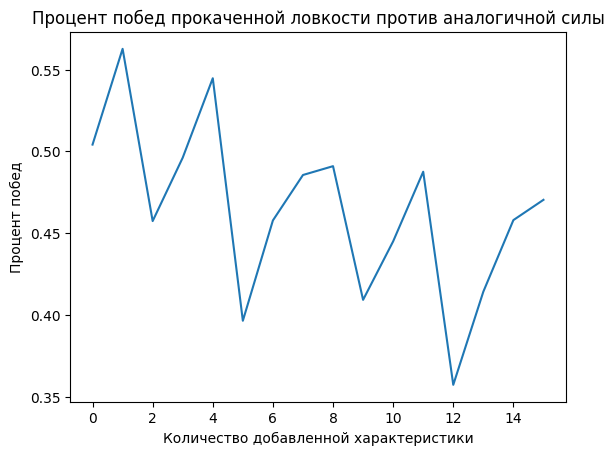

In [125]:
x = [i for i in range(count)]
percent_win = []
for i in range(count):
    wins = 0
    for _ in range(repeat):
        personage4 = empty_pers()
        personage5 = empty_pers()
        personage4.agility += i
        personage5.strength += i
        wins += 1 if battle(personage4, personage5) else 0
    percent_win.append(wins / repeat)
plt.title("Процент побед прокаченной ловкости против аналогичной силы")
plt.xlabel("Количество добавленной характеристики")
plt.ylabel("Процент побед")
plt.plot(x, percent_win)

## Л к М

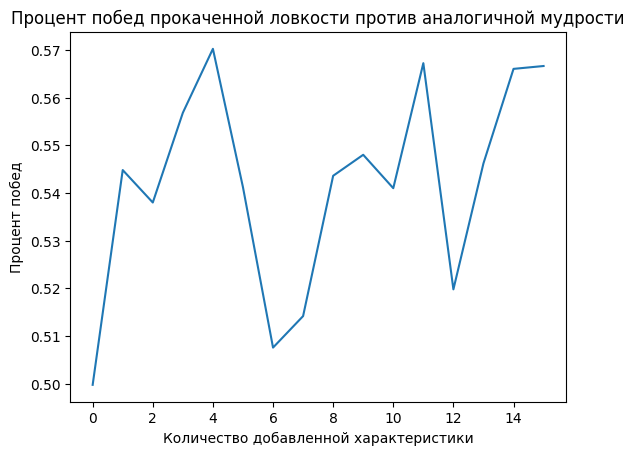

In [126]:
x = [i for i in range(count)]
percent_win = []
for i in range(count):
    wins = 0
    for _ in range(repeat):
        personage4 = empty_pers()
        personage5 = empty_pers()
        personage4.agility += i
        personage5.wisdom += i
        wins += 1 if battle(personage4, personage5) else 0
    percent_win.append(wins / repeat)
plt.title("Процент побед прокаченной ловкости против аналогичной мудрости")
plt.xlabel("Количество добавленной характеристики")
plt.ylabel("Процент побед")
plt.plot(x, percent_win)

## С к М

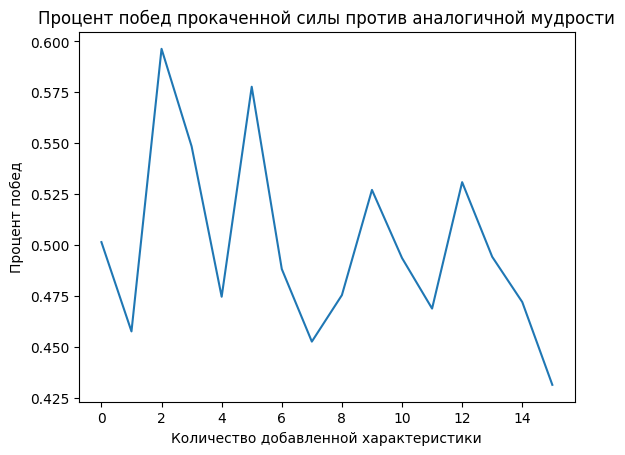

In [127]:
x = [i for i in range(count)]
percent_win = []
for i in range(count):
    wins = 0
    for _ in range(repeat):
        personage4 = empty_pers()
        personage5 = empty_pers()
        personage4.strength += i
        personage5.wisdom += i
        wins += 1 if battle(personage4, personage5) else 0
    percent_win.append(wins / repeat)
plt.title("Процент побед прокаченной силы против аналогичной мудрости")
plt.xlabel("Количество добавленной характеристики")
plt.ylabel("Процент побед")
plt.plot(x, percent_win)